In [1]:
# Cell 1: Import packages
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
%matplotlib inline

In [2]:
# Cell 2: Define Functions
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


def kriging_interpolate(distance, depth, variable, depth_window=5, distance_window=3, 
                        grid_depth=None, grid_distance=None, variogram_model="linear"):
    # If grid_depth and grid_distance are not specified, define them based on input data
    if grid_depth is None:
        grid_depth = np.arange(0, np.nanmax(depth), depth_window)
    if grid_distance is None:
        grid_distance = np.arange(np.nanmin(distance), np.nanmax(distance), distance_window)
    
    # Create meshgrid for gridded output
    gridx, gridy = np.meshgrid(grid_distance, grid_depth)

    # Initialize output array
    z = np.full(gridx.shape, np.nan)

    # Loop over the grid
    for i in range(len(grid_distance)):
        for j in range(len(grid_depth)):
            # Select points within window
            mask = (
                (distance >= grid_distance[i] - distance_window/2) &
                (distance < grid_distance[i] + distance_window/2) &
                (depth >= grid_depth[j] - depth_window/2) &
                (depth < grid_depth[j] + depth_window/2)
            )
            # Exclude NaNs within the selected window
            distance_windowed = distance[mask]
            depth_windowed = depth[mask]
            variable_windowed = variable[mask]
            valid_mask = ~np.isnan(distance_windowed) & ~np.isnan(depth_windowed) & ~np.isnan(variable_windowed)
            distance_windowed = distance_windowed[valid_mask]
            depth_windowed = depth_windowed[valid_mask]
            variable_windowed = variable_windowed[valid_mask]

            if len(variable_windowed) > 3:  # We need at least 4 points to fit a variogram
                # Create ordinary kriging object with points within window
                try:
                    OK = OrdinaryKriging(
                        distance_windowed, depth_windowed, variable_windowed, variogram_model=variogram_model,
                        verbose=False, enable_plotting=False
                    )
                    # Perform kriging over grid point
                    z[j, i], _ = OK.execute("points", grid_distance[i], grid_depth[j])
                except ValueError as ve:
                    print(f"Could not perform kriging for window centered at ({grid_distance[i]}, {grid_depth[j]}): {ve}")
    
    return gridx, gridy, z

In [3]:
# Cell 2: Load Data
# Define the path to the NetCDF files and load data
processing_mode = 'delayed'  # or realtime
deployment_name = 'batray_20230317'
nc_path = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/'+ deployment_name + '/'+ processing_mode + '/nc/'
file_pattern = nc_path + '*{}*.nc'.format('trajectory')

# Load the NetCDF file using xarray
filename = sorted(glob.glob(file_pattern))[0]  # Replace with your preferred method for selecting the file
data = xr.open_dataset(filename, engine='netcdf4', decode_times=False)
data_df = data.sortby('time').to_dataframe().reset_index()

In [4]:
# Cell 3: interpolate gaps in the data
# Convert Unix timestamps to DateTime
datetime_index = pd.to_datetime(data_df['time'], unit='s')

# Compute the time difference between each point and the next
time_diff = datetime_index.diff()

# Create a mask where the time difference is less than 1 minute
mask = (time_diff <= pd.Timedelta(minutes=1))

# Copy the original DataFrame
interpolated_df = data_df.copy()

# Interpolate where the time difference is less than 1 minute
for col in ['lat_qc', 'lon_qc', 'depth', 'temperature','salinity','oxygen_concentration']:
    data_df.loc[mask, col] = data_df.loc[mask, col].interpolate()

In [7]:
# Cell 4: Bin average data
# Create a DataFrame 
df = data_df.copy()

# Round depth to the nearest bin_size
bin_size = 0.5
df['depth_scaled'] = (df['depth'] / bin_size).round() * bin_size

# Group by profile_index and depth_scaled, then calculate the mean
df_binavg = df.groupby(['profile_index', 'depth_scaled']).mean().reset_index()

# Drop the original 'depth' column
df_binavg = df_binavg.drop('depth', axis=1)

# Rename 'depth_scaled' to 'depth'
df_binavg.rename(columns={'depth_scaled': 'depth'}, inplace=True)

df_binavg.dropna(subset=['lat_qc'], inplace=True) # get rid of spurious nan's


In [8]:
# Cell 5: Compute Distance
# Vectorized haversine function
haversine_vec = np.vectorize(haversine)

lat, lon = df_binavg['lat_qc'], df_binavg['lon_qc']
lat1, lon1 = lat[:-1], lon[:-1]
lat2, lon2 = lat[1:], lon[1:]

# Add the cumulative distance to the DataFrame
df_binavg['track_distance'] = np.concatenate(([0], np.cumsum(haversine_vec(lat1, lon1, lat2, lon2))))

In [19]:
# Cell 6: Krigging of Select Data Variables
# Extract distance and depth vectors
distance = df_binavg['track_distance'].to_numpy()
depth = df_binavg['depth'].to_numpy()

# Bin sizes
xres,yres = 3,5

# Interpolate temperature
gridx_temp, gridy_temp, temp_interp = kriging_interpolate(distance, depth, df_binavg['temperature'].to_numpy(),depth_window=yres, distance_window=xres)

# Interpolate salinity
gridx_sal, gridy_sal, sal_interp = kriging_interpolate(distance, depth, df_binavg['salinity'].to_numpy(),depth_window=yres, distance_window=xres)

# Interpolate oxygen concentration
gridx_oxy, gridy_oxy, oxy_interp = kriging_interpolate(distance, depth, df_binavg['oxygen_concentration'].to_numpy(),depth_window=yres, distance_window=xres)



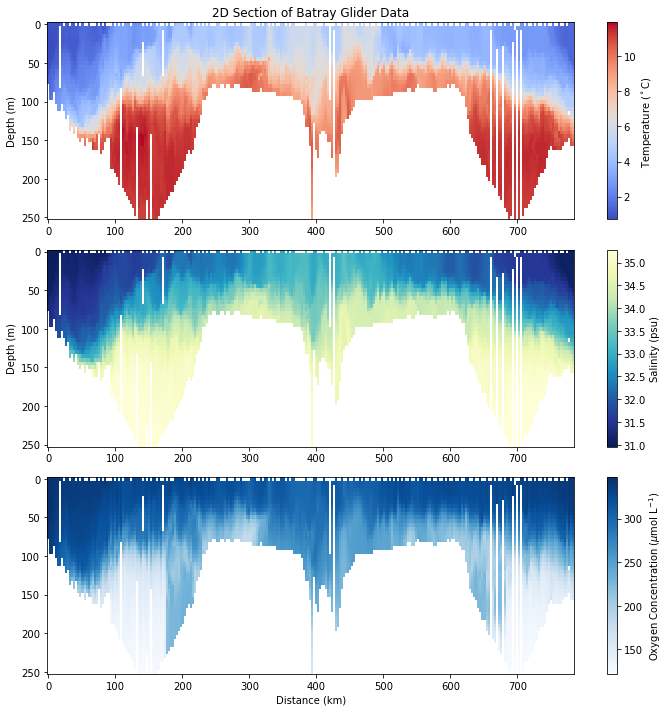

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3,1, figsize=(10, 10))

# Plot temperature
im1 = axs[0].pcolormesh(gridx_temp, gridy_temp, temp_interp, cmap='coolwarm')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('2D Section of Batray Glider Data')
axs[0].invert_yaxis()
fig.colorbar(im1, ax=axs[0], label=r'Temperature ($^\circ$C)')

# Plot salinity
im2 = axs[1].pcolormesh(gridx_sal, gridy_sal, sal_interp, cmap='YlGnBu_r')
axs[1].set_ylabel('Depth (m)')
axs[1].invert_yaxis()
fig.colorbar(im2, ax=axs[1], label=r'Salinity (psu)')

im3 = axs[2].pcolormesh(gridx_oxy, gridy_oxy, oxy_interp, cmap='Blues')
axs[2].set_xlabel('Distance (km)')
axs[2].invert_yaxis()
fig.colorbar(im3, ax=axs[2], label=r'Oxygen Concentration ($\mu$mol L$^{-1}$)')

plt.tight_layout()
plt.show()
figname = deployment_name + '_' + processing_mode + '_section.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='white')

